<a href="https://www.kaggle.com/code/duynhatvo/clashroyale?scriptVersionId=93695181" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Clash Royale Dataset Analysis

## 1. Introduction

In this notebook, we are going to analyze the [Clash Royale Dataset](https://www.kaggle.com/datasets/nonrice/clash-royale-battles-upper-ladder-december-2021). This dataset documents over 700 thousands matches of the mobile game [Clash Royale](https://clashroyale.com/) by Supercell. We will first brief through the basic mechanics of the games and the goal of this project, then the analysis and conclusion part.

## 2. Objectives:
### a. Clash Royale:
Clash Royale is a realtime strategy mobile game, where 2 players fight over a 3-minute match to destroy their opponent's towers. Each player will have a prechosen deck consisting of 8 cards, and will continuously deploy their cards which are either minions or spells. The game ends after 3 minutes, or if a player's main tower is destroyed.

As simple as it may sound, analyzing who would win a match is very difficult, due to the huge permutations of cards (there are 106 cards in total), as well as the different players' skills. In this notebook, we are going to analyze the dataset with the following assumptions:
- The matches happen in a small time span (December 2021), and no update (tweaks to each card's stats) are done.
- The matches happen between the top-ranked players in the world, and they all have very similar skills.

### b. Our approach:
In this notebook, we are going to try and see whether we can predict an outcome of a match using the decks and the rank of each player.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clash-royale-battles-upper-ladder-december-2021/data_ord.csv
/kaggle/input/clash-royale-battles-upper-ladder-december-2021/cardlist.csv


## 3. Preliminary Analysis:
### a. A brief overview:
We are first going to have a quick look to get a sense of the data. As the dataset has over 700 thousand points, we are first going to only use the first 20 thousand to reduce computing power, before generalizing to bigger dataset.

We then have a look at the dataset, and its correlation matrix.

In [2]:
df_full = pd.read_csv('../input/clash-royale-battles-upper-ladder-december-2021/data_ord.csv')
df_full.drop(columns='Unnamed: 0', inplace=True)
card_names = pd.read_csv('../input/clash-royale-battles-upper-ladder-december-2021/cardlist.csv')['card']
N_CARDS = card_names.shape[0]

In [3]:
SIZE = 50000
df = df_full.sample(SIZE, random_state=84, ignore_index=True)
df

,p1card1,p1card2,p1card3,p1card4,p1card5,p1card6,p1card7,p1card8,p2card1,p2card2,p2card3,p2card4,p2card5,p2card6,p2card7,p2card8,p1trophies,p2trophies,outcome
0,16,34,39,42,73,97,99,102,0,1,10,72,80,82,87,98,6564,6556,0
1,0,21,37,45,49,55,95,99,15,16,18,21,27,42,55,57,6399,6422,1
2,12,15,29,35,49,57,87,100,8,15,29,41,57,77,87,88,6496,6533,0
3,15,24,35,39,42,85,87,102,37,43,63,65,66,88,89,103,6478,6486,0
4,9,13,15,18,39,48,88,94,12,17,18,31,51,93,98,101,6558,5999,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,4,6,15,21,27,42,92,99,4,27,42,62,69,87,95,97,6207,6156,1
49996,11,19,32,58,62,78,87,99,7,18,24,49,88,89,94,102,7012,5436,0
49997,10,11,21,31,68,80,98,101,10,11,45,59,85,98,99,101,7012,6975,1
49998,19,32,37,41,49,55,56,104,14,27,41,51,64,83,87,102,6029,6051,1


In [4]:
df.describe()

,p1card1,p1card2,p1card3,p1card4,p1card5,p1card6,p1card7,p1card8,p2card1,p2card2,p2card3,p2card4,p2card5,p2card6,p2card7,p2card8,p1trophies,p2trophies,outcome
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.245460,22.134320,32.665980,44.668940,57.977660,75.382340,89.544620,97.705720,10.474220,20.681060,30.814220,42.466700,55.696620,73.041040,88.140900,96.845520,6459.528180,6384.847880,0.558020
std,11.087704,13.275504,14.529224,16.239462,17.476594,16.617522,10.062906,4.591059,10.082976,12.799591,14.668216,16.687725,18.266478,18.056733,11.841885,5.566629,403.530226,455.356235,0.496627
min,0.000000,1.000000,2.000000,5.000000,7.000000,12.000000,16.000000,24.000000,0.000000,1.000000,2.000000,5.000000,7.000000,13.000000,14.000000,22.000000,315.000000,88.000000,0.000000
25%,4.000000,12.000000,21.000000,33.000000,43.000000,63.000000,87.000000,95.000000,4.000000,11.000000,18.000000,31.000000,42.000000,61.000000,87.000000,95.000000,6188.000000,6115.000000,0.000000
50%,9.000000,18.000000,32.000000,42.000000,56.000000,80.000000,91.000000,98.000000,9.000000,16.000000,29.000000,41.000000,55.000000,78.000000,89.000000,98.000000,6411.000000,6355.000000,1.000000
75%,12.000000,31.000000,42.000000,55.000000,72.000000,88.000000,95.000000,102.000000,12.000000,27.000000,41.000000,53.000000,70.000000,88.000000,95.000000,100.000000,6675.000000,6633.000000,1.000000
max,87.000000,90.000000,92.000000,96.000000,101.000000,102.000000,104.000000,105.000000,87.000000,90.000000,93.000000,98.000000,101.000000,102.000000,104.000000,105.000000,8327.000000,8415.000000,1.000000


In [5]:
corr = df.corr()

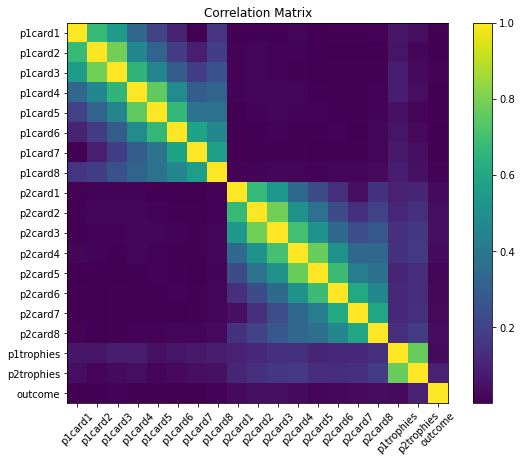

In [6]:
f = plt.figure(figsize=(9, 7))
plt.imshow(np.abs(corr))
plt.title('Correlation Matrix')
plt.xticks(np.arange(df.shape[1]), df.columns, rotation=45)
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.colorbar()
plt.show()

#### Remarks:
From the plotted correlation matrix, we observe that there seems to be a clear relationship between:
- The cards in each player decks
- The players' rankings
- The rankings and the cards

This makes sense, as cards often have synergies (i.e some go well with others while some does not). The players' rankings should be correlated as well, as the game "match-make" based on their respective rankings, and players of different rankings seems to use similar decks of cards.

However, unfortunately, it appears that there is very little correlation between the outcome and any other attributes. We can try to apply some well-known classifications methods, but none seems to give a good prediction of the outcome.

### b. Basic Algorithms:
In the following cells we do the following:
1. We first encode each players' deck into $1 \times 106$ vectors, where $V_i = 1$ if the $i^{th}$ card is in the deck, $0$ otherwise. This seems to be a better choice than one-hot encoding, as there are $\begin{pmatrix}106 \\ 8 \end{pmatrix} \approx 3 \times 10^{11}$ possible choices of decks.
2. We then split the whole data set into training sets and test sets for supervised classification. We also keep a list of all decks choice people used to see if unsupervised learning give us some better insights into the data set.
3. We then apply some well-known simple Classification methods (e.g KNN, Decsion Trees, etc.) to see if we get a good result.

In [7]:
from sklearn.model_selection import train_test_split
y_train = df['outcome']
x_train, decks = [], []

# we first combine the DataFrame into 1x106 vectors, where V[i] = 1 if the ith card is in the deck
# this 
for i in range(df.shape[0]):
    p1 = np.zeros(106)
    p2 = np.zeros(106)
    for j in range(1, 9):
        p1[df[f'p1card{j}'][i]] = 1
        p2[df[f'p2card{j}'][i]] = 1
    decks.append(p1)
    decks.append(p2)
    x_train.append(np.concatenate((p1, p2)))
    
x_train = np.array(x_train)
decks = np.array(decks)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=6233)
d_train, d_test = train_test_split(decks, test_size=0.2, random_state=47483)

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [9]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print('Training accuracy:\t', knn.score(x_train, y_train))
print('Testing accuracy:\t', knn.score(x_test, y_test))

Training accuracy:	 0.70965
Testing accuracy:	 0.5422


In [10]:
# ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))
# ada.fit(x_train, y_train)
# print('Training accuracy:\t', ada.score(x_train, y_train))
# print('Testing accuracy:\t', ada.score(x_test, y_test))

In [11]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=20))
bagging.fit(x_train, y_train)
print('Training accuracy:\t', bagging.score(x_train, y_train))
print('Testing accuracy:\t', bagging.score(x_test, y_test))

Training accuracy:	 0.8306
Testing accuracy:	 0.5464


In [12]:
extra = ExtraTreesClassifier(max_depth=20)
extra.fit(x_train, y_train)
print('Training accuracy:\t', extra.score(x_train, y_train))
print('Testing accuracy:\t', extra.score(x_test, y_test))

Training accuracy:	 0.90665
Testing accuracy:	 0.5711


In [13]:
rf = RandomForestClassifier(max_depth=20)
rf.fit(x_train, y_train)
print('Training accuracy:\t', rf.score(x_train, y_train))
print('Testing accuracy:\t', rf.score(x_test, y_test))

Training accuracy:	 0.853775
Testing accuracy:	 0.5708


#### Remarks:
Unfortunately, our models does not seem to have a good predictions overall (the score is only a bit better than random guessing). In the following parts of the notebook, we are going to see if we could obtain a better fit on this dataset.

## 4. Decks Analysis:
Let us dig deeper into the dataset by analyzing the decks, which seems to be most correlated.

We first visualize the correlation matrix (now with the new encoding).

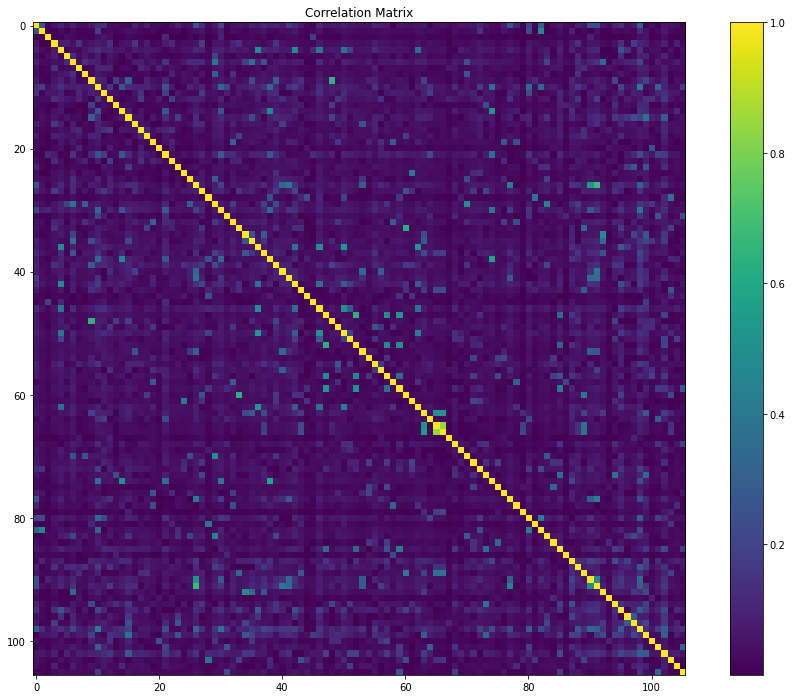

In [14]:
d_corr = np.corrcoef(decks.T)
f = plt.figure(figsize=(16, 12))
plt.imshow(np.abs(d_corr))
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

#### Remarks:
We want to observe which pairs have the highest synergy. The following cells sets all correlation under the diagonal to 0, and sort them by value.

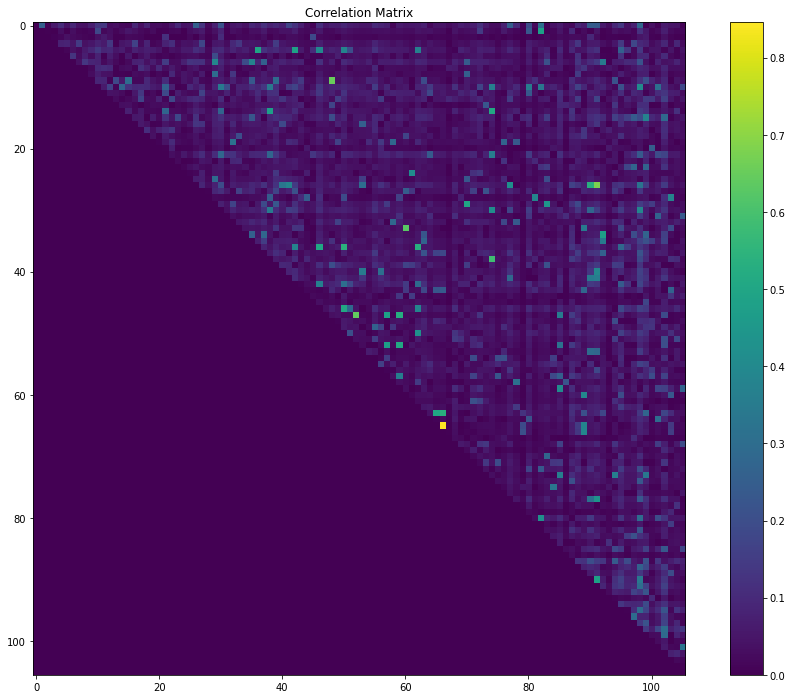

In [15]:
d_corr_u = np.triu(d_corr, k=1)
d_corr_u
f = plt.figure(figsize=(16, 12))
plt.imshow(np.abs(d_corr_u))
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

In [16]:
d_corr_flat = d_corr_u.flatten()
d_corr_argsort = np.argsort(d_corr_flat)
d_corr_high = [(x // 106, x % 106, d_corr_flat[x]) for x in d_corr_argsort[:-31:-1]]
d_corr_low = [(x // 106, x % 106, d_corr_flat[x]) for x in d_corr_argsort[:30]]

In [17]:
[(card_names[x], card_names[y], z) for (x, y, z) in d_corr_high]

[('Elixir Golem', 'Battle Healer', 0.8457419116286431),
 ('Princess', 'Goblin Barrel', 0.6804998111880078),
 ('Golem', 'Night Witch', 0.6511870518565671),
 ('Royal Recruits', 'Zappies', 0.642733862846637),
 ('Sparky', 'Goblin Giant', 0.6290057429443017),
 ('Ice Golem', 'Cannon', 0.5850744466731844),
 ('Battle Ram', 'Royal Ghost', 0.5399496095665615),
 ('Electro Dragon', 'Battle Healer', 0.5367758144337856),
 ('Princess', 'Rocket', 0.5351268736602662),
 ('Battle Ram', 'Magic Archer', 0.5292072137618353),
 ('Royal Recruits', 'Royal Hogs', 0.526451534994538),
 ('Musketeer', 'Cannon', 0.511040982110212),
 ('Zappies', 'Royal Hogs', 0.5103100011562784),
 ('Bandit', 'Royal Ghost', 0.5085755820949488),
 ('Electro Dragon', 'Elixir Golem', 0.5033786785612582),
 ('Battle Ram', 'Bandit', 0.5023515394539955),
 ('Lava Hound', 'Skeleton Dragons', 0.49988596374518246),
 ('P.E.K.K.A', 'Battle Ram', 0.498850310992887),
 ('P.E.K.K.A', 'Electro Wizard', 0.48470822333617747),
 ('Bowler', 'Freeze', 0.481547

In [18]:
[(card_names[x], card_names[y], z) for (x, y, z) in d_corr_low]

[('The Log', 'Barbarian Barrel', -0.30033325189736393),
 ('Zap', 'The Log', -0.29125419772895056),
 ('Arrows', 'The Log', -0.26221933193719194),
 ('Fireball', 'Lightning', -0.24427885023297868),
 ('Zap', 'Barbarian Barrel', -0.22041946481666463),
 ('Inferno Dragon', 'The Log', -0.2175884019202871),
 ('Balloon', 'The Log', -0.21461371342156568),
 ('Skeletons', 'Zap', -0.2112841906022062),
 ('Fireball', 'Tornado', -0.20518241221229278),
 ('Fireball', 'Rocket', -0.20398365022047577),
 ('Fireball', 'Poison', -0.1919857269070475),
 ('Baby Dragon', 'The Log', -0.1914215742054577),
 ('Arrows', 'Tornado', -0.18385956527384376),
 ('Zap', 'Tornado', -0.1724789055895459),
 ('Electro Wizard', 'The Log', -0.17214012616029922),
 ('Skeletons', 'Electro Wizard', -0.17203138905353918),
 ('Hog Rider', 'Barbarian Barrel', -0.171893088197948),
 ('Valkyrie', 'Dark Prince', -0.16793744972814798),
 ('Mega Knight', 'The Log', -0.16768985395837072),
 ('Skeletons', 'Arrows', -0.16661458458791198),
 ('Princess',

#### Remarks:
We observe that these card pairs are very common in the strongest decks (from https://www.deckshop.pro/).

## 5. A deeper look at Outcome:
### a. Applying PCA:

In [19]:
data = np.copy(x_train).T.tolist()
data.append(y_train)
data = np.array(data)

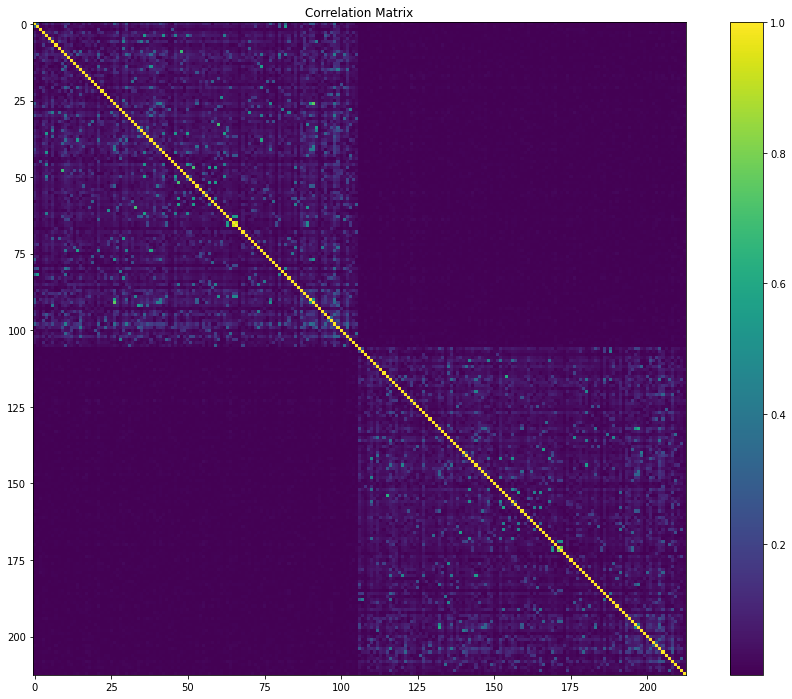

In [20]:
corr = np.corrcoef(data)
f = plt.figure(figsize=(16, 12))
plt.imshow(np.abs(corr))
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
x_train_pca = pca.fit_transform(x_train)

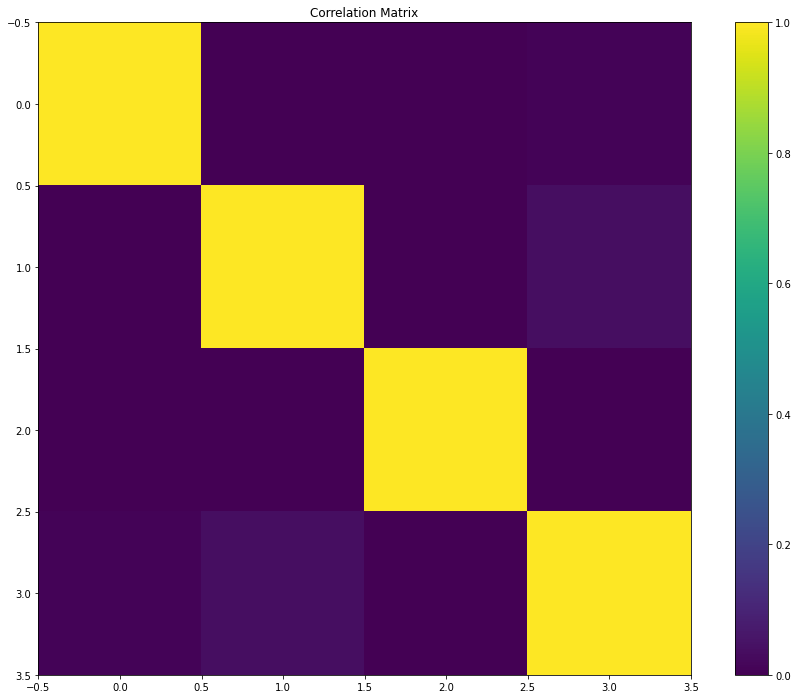

In [22]:
data = np.copy(x_train_pca).T.tolist()
data.append(y_train)
data = np.array(data)
corr = np.corrcoef(data)
f = plt.figure(figsize=(16, 12))
plt.imshow(np.abs(corr))
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

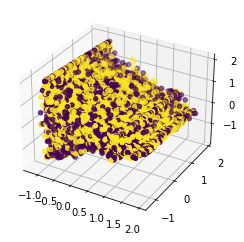

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_train_pca[:,0].flatten(), x_train_pca[:, 1].flatten(), x_train_pca[:, 2].flatten(), c = y_train.tolist())

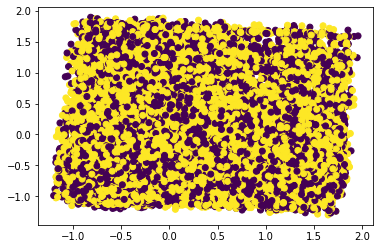

In [24]:
plt.scatter(x_train_pca[:,0].flatten(), x_train_pca[:, 1].flatten(), c = y_train.tolist())

In [25]:
# ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15))
# ada.fit(x_train_pca, y_train)
# print('Training accuracy:\t', ada.score(x_train_pca, y_train))
# print('Testing accuracy:\t', ada.score(pca.transform(x_test), y_test))

In [26]:
extra = ExtraTreesClassifier(max_depth=15)
extra.fit(x_train_pca, y_train)
print('Training accuracy:\t', extra.score(x_train_pca, y_train))
print('Testing accuracy:\t', extra.score(pca.transform(x_test), y_test))

Training accuracy:	 0.73685
Testing accuracy:	 0.5534


### b. How about Neural Network?
Let's try to see if we can instead obtain a good score using Neural Network. 

We first try a naive Neural Network, with all layers are dense, and two Dropouts.

In [27]:
from tensorflow import keras
nn = keras.Sequential([
    keras.layers.Dense(128, activation='ReLU'),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(16, activation='ReLU'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(4, activation='ReLU'),
    keras.layers.Dense(1, activation='sigmoid'),
])
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
nn.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=['accuracy'],
)
nn.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=16, callbacks=[early_stopping])

2022-04-22 07:22:43.988809: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-22 07:22:44.160480: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
2250/2250 [==============================] - 7s 3ms/step - loss: 0.8394 - accuracy: 0.5124 - val_loss: 0.7792 - val_accuracy: 0.5153
Epoch 2/10
2250/2250 [==============================] - 6s 3ms/step - loss: 0.8121 - accuracy: 0.5111 - val_loss: 0.7594 - val_accuracy: 0.5153
Epoch 3/10
2250/2250 [==============================] - 6s 3ms/step - loss: 0.7935 - accuracy: 0.5148 - val_loss: 0.7464 - val_accuracy: 0.5138
Epoch 4/10
2250/2250 [==============================] - 6s 3ms/step - loss: 0.7776 - accuracy: 0.5184 - val_loss: 0.7380 - val_accuracy: 0.5130
Epoch 5/10
2250/2250 [==============================] - 6s 3ms/step - loss: 0.7694 - accuracy: 0.5123 - val_loss: 0.7331 - val_accuracy: 0.5128
Epoch 6/10
2250/2250 [==============================] - 6s 3ms/step - loss: 0.7563 - accuracy: 0.5123 - val_loss: 0.7253 - val_accuracy: 0.5145
Epoch 7/10
2250/2250 [==============================] - 6s 3ms/step - loss: 0.7501 - accuracy: 0.5132 - val_loss: 0.7230 - val_accuracy:

In [28]:
nn.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.7032 - accuracy: 0.5224


[0.7032221555709839, 0.5224000215530396]

#### Remarks: 
The previous one did not really give a very good score, so let's try to see if we could use a different network structure.

Through the previous analysis on Decks, we observe that a deck is characterized by a small number of cards. With that in mind, it makes sense to use CNN on this model, as in the following cell.

In [29]:
from tensorflow import keras
cnn = keras.Sequential([
    keras.layers.Dense(212, activation='relu'),
    keras.layers.Conv1D(32, 4, padding='same', activation='relu'),
    keras.layers.Conv1D(32, 4, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool1D(8),
    keras.layers.Conv1D(64, 4, activation='relu'),
    keras.layers.Conv1D(64, 4, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool1D(8),
    keras.layers.Dense(128, activation='ReLU'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
cnn.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=['accuracy'],
)
cnn.fit(x_train.reshape((x_train.shape[0], x_train.shape[1], 1)), y_train, validation_split=0.1, epochs=30, batch_size=16, callbacks=[early_stopping])

Epoch 1/30
2250/2250 [==============================] - 50s 21ms/step - loss: 0.7549 - accuracy: 0.4760 - val_loss: 0.6993 - val_accuracy: 0.4991
Epoch 2/30
2250/2250 [==============================] - 48s 22ms/step - loss: 0.7002 - accuracy: 0.5137 - val_loss: 0.6932 - val_accuracy: 0.5428
Epoch 3/30
2250/2250 [==============================] - 48s 21ms/step - loss: 0.6934 - accuracy: 0.5334 - val_loss: 0.6912 - val_accuracy: 0.5530
Epoch 4/30
2250/2250 [==============================] - 47s 21ms/step - loss: 0.6916 - accuracy: 0.5412 - val_loss: 0.7030 - val_accuracy: 0.5558
Epoch 5/30
2250/2250 [==============================] - 49s 22ms/step - loss: 0.6912 - accuracy: 0.5441 - val_loss: 0.6911 - val_accuracy: 0.5531
Epoch 6/30
2250/2250 [==============================] - 48s 21ms/step - loss: 0.6898 - accuracy: 0.5489 - val_loss: 0.6892 - val_accuracy: 0.5580
Epoch 7/30
2250/2250 [==============================] - 50s 22ms/step - loss: 0.6895 - accuracy: 0.5496 - val_loss: 0.6881 -

In [30]:
cnn.evaluate(x_test.reshape((x_test.shape[0], x_test.shape[1], 1)), y_test)

313/313 [==============================] - 4s 10ms/step - loss: 0.6857 - accuracy: 0.5609


[0.6856525540351868, 0.560949981212616]

#### Remarks:
The result indeed looks much better than our naive model. We observe that indeed, it is better to look at a match in terms of the main cards used in each battle.

However, it appears that, unfortunately, we cannot really get a much better prediction of outcome than decision trees.

Still, with our previous analysis, it seems that we could try and get a good result at deck building.

## 6. Deck Building:

In [31]:
synergies = np.array([(i, j, d_corr[i][j]) for i in range(N_CARDS) for j in range(i+1, N_CARDS)])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

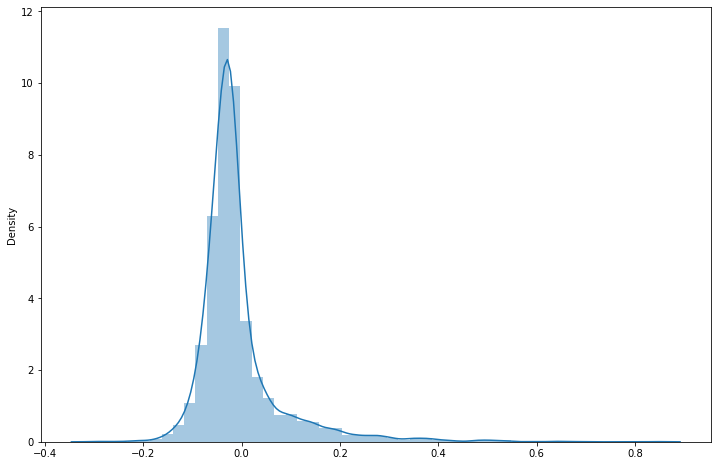

In [32]:
import seaborn as sns
x_train, y_train = synergies[:, :2], synergies[:, 2]
fig = plt.figure(figsize=(12, 8))
sns.distplot(y_train)